<a href="https://colab.research.google.com/github/zhihong1224/CNN_Demo/blob/master/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Setup

In [36]:
import os
import numpy as np
import torch
from torch import nn,optim
import torch.utils.data as Data
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

train_on_gpu=torch.cuda.is_available()
if not train_on_gpu:
  print('cuda is not available! training on cpu...')
  device=torch.device('cpu')
else:
  print('cuda is available! training on gpu...')
  device=torch.device('cuda')

cuda is available! training on gpu...


# 2 准备数据

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
data_dir='./gdrive/My Drive/Colab Notebooks/data/flower_photos/flower_photos/'
os.listdir(data_dir)

['roses', 'sunflowers', 'tulips', 'dandelion', 'daisy']

In [74]:
trans=transforms.Compose([
  transforms.RandomResizedCrop(224),
  transforms.ToTensor()
])
train_data_all=datasets.ImageFolder(data_dir,transform=trans)
len(train_data_all),train_data_all.class_to_idx

(3670, {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4})

In [0]:
indices=np.random.permutation(len(train_data_all))
valid_ratio=0.2
test_ratio=0.2
valid_num=int(len(train_data_all)*valid_ratio)
test_num=int(len(train_data_all)*(valid_ratio+test_ratio))

In [0]:
batch_size=64

In [0]:
valid_sampler=SubsetRandomSampler(indices[:valid_num])
valid_iter=Data.DataLoader(train_data_all,batch_size=batch_size,sampler=valid_sampler,num_workers=4)

In [0]:
test_sampler=SubsetRandomSampler(indices[valid_num:test_num])
test_iter=Data.DataLoader(train_data_all,batch_size=batch_size,sampler=test_sampler,num_workers=4)

In [0]:
train_sampler=SubsetRandomSampler(indices[test_num:])
train_iter=Data.DataLoader(train_data_all,batch_size=batch_size,sampler=train_sampler,num_workers=4)

In [0]:
classes=['daisy','dandelion','rose','sunflowers','tulips']

In [89]:
for X,Y in valid_iter:
  print(X.shape,Y.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([30, 3, 224, 224]) torch.Size([30])


# 3 数据感知

In [0]:
def show_data(data_iter,show_num=batch_size):
  import math
  show_iter=iter(data_iter)
  show_data=next(show_iter)
  img,label=show_data
  fig=plt.figure()
  rows=math.sqrt(show_num)
  cols=math.ceil(show_num/rows)
  for i in range(show_num):
    ax=fig.add_subplot(rows,cols,i+1,xticks=[],yticks=[])
    ax.imshow(img[i].permute(1,2,0))
    ax.set_title(classes[label[i].item()])

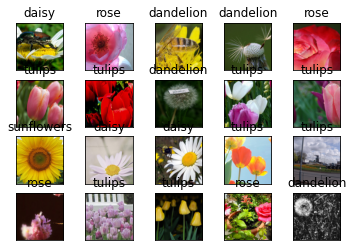

In [59]:
show_data(valid_iter)

# 4 定义模型

In [82]:
vgg16=models.vgg16(pretrained=True);vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
for param in vgg16.features.parameters():
  param.requires_grad=False

In [0]:
vgg16.classifier[6]=nn.Linear(4096,5)

# 5 训练

In [0]:
def evaluate_acc(model,data_iter):
  model.eval()
  acc,n=0.0,0
  with torch.no_grad():
    for X,Y in data_iter:
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      acc+=(y_pred.argmax(dim=1)==Y).sum().item()
      n+=Y.shape[0]
    return acc/n

In [0]:
def train(model,num_epochs,lr,train_iter,valid_iter):
  model=model.to(device)
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.Adam(model.parameters(),lr)
  train_loss_list,valid_loss_list=[],[]
  valid_min_loss=np.inf

  for epoch in range(num_epochs):
    train_loss,valid_loss=0.0,0.0
    model.train()
    for X,Y in train_iter:
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      loss=criterion(y_pred,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()*X.shape[0]
      train_loss_list.append(loss.item())
      print('train iter loss:',loss.item())
    model.eval()
    for X,Y in valid_iter:
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      loss=criterion(y_pred,Y)
      valid_loss+=loss.item()*X.shape[0]
      valid_loss_list.append(loss.item())
      print('valid iter loss:',loss.item())
    train_loss=train_loss/len(train_iter.sampler)
    valid_loss=valid_loss/len(valid_iter.sampler)
    train_acc=evaluate_acc(model,train_iter)
    valid_acc=evaluate_acc(model,valid_iter)
    if valid_loss<valid_min_loss:
      print('validation decreased:{}-->{}.saving model...'.format(valid_min_loss,valid_loss))
      valid_min_loss=valid_loss
      torch.save(model.state_dict(),'model.pt')
    print('epoch:{},train loss:{},valid loss:{},train acc:{},valid acc:{}'.\
          format(epoch+1,train_loss,valid_loss,train_acc,valid_acc))
    print('\n')
  return train_loss_list,valid_loss_list

In [92]:
num_epochs,lr=1,0.001
train_loss_list,valid_loss_list=train(vgg16,num_epochs,lr,train_iter,valid_iter)

train iter loss: 0.6527364253997803
train iter loss: 0.9777066111564636
train iter loss: 0.646899402141571
train iter loss: 1.7504725456237793
train iter loss: 1.2775578498840332
train iter loss: 0.7855088710784912
train iter loss: 1.1959667205810547
train iter loss: 0.9868847131729126
train iter loss: 0.8369302749633789
train iter loss: 0.6193223595619202
train iter loss: 0.7335898876190186
train iter loss: 0.7223549485206604
train iter loss: 0.6540284156799316
train iter loss: 0.8728063702583313
train iter loss: 0.7516463398933411
train iter loss: 0.9015255570411682
train iter loss: 0.7816694974899292
train iter loss: 0.5077112317085266
train iter loss: 0.4756750762462616
train iter loss: 0.4884312152862549
train iter loss: 0.7306220531463623
train iter loss: 0.646462619304657
train iter loss: 0.6357402801513672
train iter loss: 0.542902946472168
train iter loss: 0.7242537140846252
train iter loss: 0.8897449970245361
train iter loss: 0.7437660694122314
train iter loss: 0.958228290081

In [95]:
vgg16.load_state_dict(torch.load('model.pt'))
print('test acc:',evaluate_acc(vgg16,test_iter))

test acc: 0.8092643051771117


In [0]:
def predict(model,data_iter,show_num):
  import math
  show_iter=iter(data_iter)
  show_data=next(show_iter)
  img,label=show_data
  img=img.to(device)
  label=label.to(device)
  pred=model(img).argmax(dim=1)
  fig=plt.figure()
  fig.subplots_adjust(left=0,right=0.5,bottom=0.1,top=1,hspace=0.05,wspace=0.05)
  rows=math.sqrt(show_num)
  cols=math.ceil(show_num/rows)
  for i in range(show_num):
    ax=fig.add_subplot(rows,cols,i+1,xticks=[],yticks=[])
    ax.imshow(img[i].permute(1,2,0).cpu().numpy())
    ax.set_title('{}({})'.format(int(pred[i].item()),int(label[i].item())),\
            c=('green' if pred[i]==label[i] else 'red'))

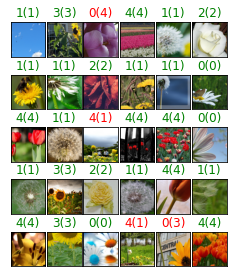

In [118]:
predict(vgg16,test_iter,30)